<a href="https://colab.research.google.com/github/Fulim13/Parallel-Computing-Learning/blob/main/Practical8/00_DisplayImagesWithOpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading Images and Displaying Within The Notebook**

This will be a simple exercise to load images into the memory and displaying them. We will use OpenCV to help with the job. OpenCV is pre-installed in the Colab environment, so we don't have to install it.

## **Uploading Images to Colab for this Experiment**

To get started, we need some images, which you can manually upload from your PC. To do that, click on the `upload' icon as shown below.

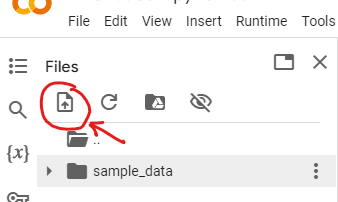


## **Download Images From the Web**

You can also download images from the web. The following `wget` commands download 3 images from the web. You can add more if you wish.

image pixel website - will check whether you are machine or human, so we using Mozila browser to access the image

In [ ]:
# Get images from the web
!wget https://cdn2.techbang.com/system/excerpt_images/54164/original/791d4f1acb0144bbd7cd761349230fe3.jpeg -O lena.jpeg
!wget https://as1.ftcdn.net/v2/jpg/03/00/09/16/1000_F_300091669_YYN79gxWZkfxAYxtDuGAipzhqXP6Wcfv.jpg -O rose.jpg
!wget --user-agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36" https://images.pexels.com/photos/1054666/pexels-photo-1054666.jpeg -O elephant_large.jpg

--2025-01-06 17:22:02--  https://cdn2.techbang.com/system/excerpt_images/54164/original/791d4f1acb0144bbd7cd761349230fe3.jpeg
Resolving cdn2.techbang.com (cdn2.techbang.com)... 18.239.94.16, 18.239.94.54, 18.239.94.72, ...
Connecting to cdn2.techbang.com (cdn2.techbang.com)|18.239.94.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90069 (88K) [image/jpeg]
Saving to: ‘lena.jpeg’

lena.jpeg           100%[===================>]  87.96K  55.4KB/s    in 1.6s    

2025-01-06 17:22:05 (55.4 KB/s) - ‘lena.jpeg’ saved [90069/90069]

--2025-01-06 17:22:05--  https://as1.ftcdn.net/v2/jpg/03/00/09/16/1000_F_300091669_YYN79gxWZkfxAYxtDuGAipzhqXP6Wcfv.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347213 (339K) [image/jpeg]
Saving to: ‘rose.jpg’

rose.jpg            100%[===================>] 3


## **Overcoming Limitation of Colab**

There is a slight problem displaying images in Colab. Most OpenCV functions work just fine under Colab. However, Colab does not allow easy way to display images unless the OpenCV program is written in Python language and execute directly in the cell. But, in this exercise, we want to write OpenCV in C++. One way to overcome this is by first saving the images into files in whatever image format you desired and then manually open the images one by one to observe the result.

In this exercise, we want to display the images directly from C++ program. To do this, we will use an interprocess communication protocol called `named pipe` by setting up the channel between the C++ program and a Python code running in the cell. Whenever, the C++ wants to display an image, it sends the image through the pipe and the Python code helps to display it. We need a C++ stub and a Python stub, which act as proxies between our program in C++ and Python.

## **C++ Stub**

The following is the C++ stub, called `cv_pipe` that needs to be compiled together with the C++ program needing the service. [*Note: You don't need it if you wish to run this exercise in the Windows Visual Studio.*]

In [ ]:
# Header file for cv_pipe
%%writefile cv_pipe.h
#pragma once
#include <opencv2/opencv.hpp>
#include <iostream>
#include <unistd.h> // For pipe
#include <fcntl.h>  // For O_WRONLY

#define reset_getopt()    (optind = 0)

int cv_imshow(cv::Mat &image);
int init_cv_pipe_comm(int argc, char *argv[], bool verbose=false);
int finalize_cv_pipe_comm();

Writing cv_pipe.h


In [ ]:
%%writefile cv_pipe.cpp
#include "cv_pipe.h"

int fd = -1;

int open_named_pipe(char *pipe_name) {
    fd = open(pipe_name, O_WRONLY);
    if(fd < 0) {
        std::cerr << "Error: failed to open the named pipe: "
                  << pipe_name << std::endl;
    }
    return fd;
}

int cv_imshow(cv::Mat &image) {
    if(fd < 0) {
        std::cerr << "Error: no named pipe available." << std::endl;
        return -1;
    }
    // Send image size as a header
    int img_size[3] = {image.cols, image.rows, image.channels()};
    write(fd, img_size, sizeof(img_size));
    // Send the image data
    write(fd, image.data, image.total() * image.elemSize());
    return 0;
}

int init_cv_pipe_comm(int argc, char *argv[], bool verbose) {
    int c;
    char *pipe_path = NULL;

    if(verbose) {
        // Print all input arguments
        for(int i = 0; i < argc; i++) {
            std::cout << "[" << i << "] " << argv[i] << std::endl;
        }
    }
    //opterr = 0;       // Do not print error to stderr

    // Parse the option arguments. The first ':' forces getopt to be silent
    // when unknown option or missing required argument is encountered so that
    // we can manually handle them ourselves in "case ':'" and "case '?'"
    while ((c = getopt(argc, argv, ":p:")) != -1) {
        switch(c) {
            case 'p':
                pipe_path = optarg;
                break;
            case ':':
                std::cerr << "Error: option -" << static_cast<char>(optopt)
                          << " requires an argument.\n";
                return -1;
            case '?':
                // Ignore all unknown options; let the main program handles it.
                break;
        }
    }
    if(!pipe_path) {
        std::cerr << "Error: expect a pipe name but none found. Try the "
                  << "following:\n\t" << argv[0] << " -p my_pipe\n";
        return -1;
    }
    // Reset the getopt so that it can parsed again from the beginning
    reset_getopt();

    fd = open_named_pipe(pipe_path);
    return fd;
}

int finalize_cv_pipe_comm() {
    close(fd);        // Close the write end of the pipe
    return 0;
}

Writing cv_pipe.cpp


## **Python Stub**

The following is the Python stub, called `runner` that we need to invoke the compiled C++ program and help display the images sent by the C++ program. [*Note: You don't need it if you wish to run this exercise in the Windows Visual Studio.*]

In [ ]:
%%writefile runner.py
import os, sys, subprocess
import threading
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def tee_pipe(pipe, out):
    for line in pipe:
        #print(line.decode('utf-8'), end='')
        #print(line.decode('utf-8'), end='',  file=out)
        out.write(line.decode('utf-8'))

def execute(filename, *args, pipe_name='/tmp/my_pipe'):
    if not os.path.exists(pipe_name):
        os.mkfifo(pipe_name)

    # Start the subprocess. The -u option is to force the Python subprocess
    # to flush its output everytime it prints.
    proc = subprocess.Popen(
            [filename, '-p', pipe_name, *args],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
    )
    # Create threads to capture and print stdout and stderr
    t1 = threading.Thread(target=tee_pipe, args=(proc.stdout, sys.stdout))
    t2 = threading.Thread(target=tee_pipe, args=(proc.stderr, sys.stdout))
    t1.start()
    t2.start()

    with open(pipe_name, "rb") as pipe:
        while True:
            # Read the image size from the pipe
            # The 1st 4 byte is column size
            # The 2nd 4 byte is row size
            # The 3rd 4 byte is channel size
            img_header = pipe.read(12)
            if not img_header:
                break
            image_size = np.frombuffer(img_header, dtype=np.uint32)
            # Read the image data for all channels
            frame_data = pipe.read(image_size[0] * image_size[1] * image_size[2])
            if not frame_data:
                break
            frame = np.frombuffer(frame_data, dtype=np.uint8).reshape((image_size[1], image_size[0], image_size[2]))
            # Display the received frame
            cv2_imshow(frame)

    proc.wait()                 # Wait for subprocess to exit
    os.remove(pipe_name)        # Clean up the named pipe
    cv2.destroyAllWindows()

Writing runner.py


## **Main C++ Program**

This is the main C++ program that load images from the user and then display them one-by-one. There are 6 steps (2 being optional) needed for successful displaying of images from C++ program in Colab. [*Note: You don't need steps 1, 2, and 6 if you wish to run this exercise in the Windows Visual Studio.*]

1.   Include the `cv_pipe.h` C++ stub
2.   Initialize the `cv_pipe` by calling `init_cv_pipe_comm()` function
3.   Parse the option arguments from user (*optional*)
4.   Parse the non-option arguments from user (*optional*)
5.   Show the image(s) using the `cv_imshow()` function provided by the `cv_pipe.cpp`
6.   Finalize the `cv_pipe`

Steps 3 and 4 are optional. If you don't wish to parse input arguments from the user, then remove these two steps. Take note that if you remove step 3, you MUST also remove step 4. But if you remove step 4, you may keep step 3.

The program below parse only the non-option arguments, which contains image filenames given by the user.

In [ ]:
%%writefile display_image.cpp
#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include "cv_pipe.h"          // (1) Include the C++ stub

int main(int argc, char *argv[]) {
    int c;
    std::vector<char *> img_filenames;

    // (2) Initialize the cv_pipe
    init_cv_pipe_comm(argc, argv, true);

    // (3) Parse the option arguments from the user
    while ((c = getopt(argc, argv, "p:")) != -1) {
        switch (c) {
            case 'p':
                // Do nothing because it should be handled by cv_pipe
                break;
            case '?':
                // Abort when encountering an unknown option
                return -1;
        }
    }
    // (4) Parse the non-option arguments from the user
    for (int index = optind; index < argc; index++)
        // Get all filenames if any and put them in the 'img_filenames' vector
        img_filenames.push_back(argv[index]);

    // Load and display images one-by-one
    for(auto filename: img_filenames) {
        std::cout << filename << std::endl;
        // Load the filename image
        cv::Mat image = cv::imread(filename);
        if (image.empty()) {
            std::cerr << "Unable to load image: " << filename << std::endl;
            return -1;
        }
        // Resize the image if its column is more than 1024 pixels before
        // displaying. You can remove it if you wish to display in its full
        // size. (Note: Colab will resize if it is too large anyway.)
        const int MAX_SIZE = 1024;
        if(image.cols > MAX_SIZE) {
            float ratio = (float)MAX_SIZE / image.cols;
            cv::resize(image, image, cv::Size(),                            \
                      ratio, ratio, cv::INTER_LINEAR);
        }
        // (5) Show the image
        cv_imshow(image);
    }
    // (6) Finalize the cv_pipe
    return finalize_cv_pipe_comm();
}


Writing display_image.cpp


## **Compiling the Main C++ Program**

The main C++ program `display_image.cpp` needs to be compiled with the `cv_pipe.cpp` file.  Also, we need to compile with the OpenCV headers and libraries and this is handled by the `pkg-config --cflags --libs opencv4` command. We get `pkg-config` to go figure out what those are for us. The output file is named as `display_image` without an extension name.

In [ ]:
!nvcc -o display_image display_image.cpp cv_pipe.cpp `pkg-config --cflags --libs opencv4`

## **Running the Main C++ Program through Python Code**

Finally, we need to run the C++ program within the Python code running directly in the cell so that the C++ program can display the images.

The first statement is to import the `execute()` function in the `runner.py` written above. The `execute()` function runs the compiled C++ program in the cell. The 1st parameter of function is the name of the program you wish to run. All subsequent parameters are the input arguments you want to pass to the program. In our case, we pass in 3 names of images we downloaded earlier.

[0] ./display_image
[1] -p
[2] /tmp/my_pipe
[3] lena.jpeg
[4] rose.jpg
lena.jpeg
rose.jpg


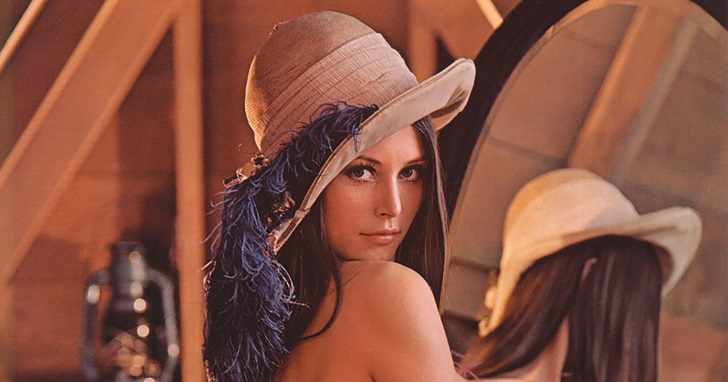

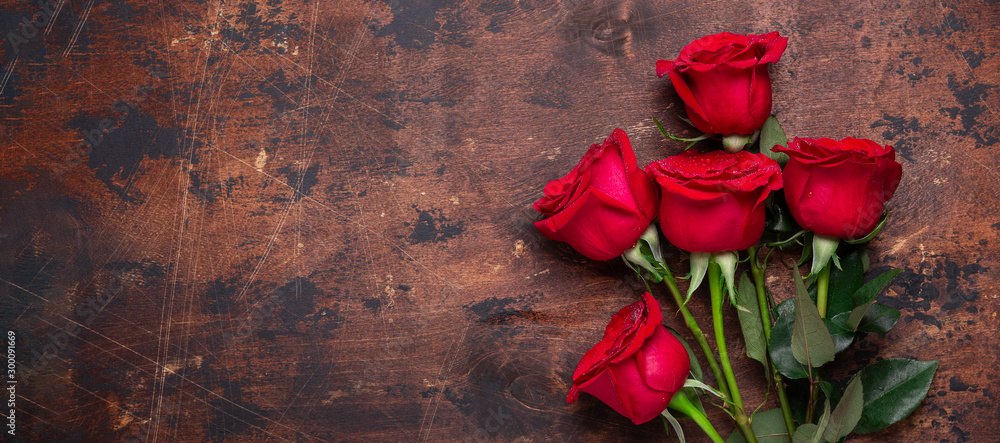

In [ ]:
from runner import execute

execute(
    # Execute the program `display_image` we built above
    "./display_image",
    # Pass the 3 image filenames downloaded from the web
    "lena.jpeg", "rose.jpg",
    # "elephant_large.jpg",
)